# Neural Network-Based Image Processing on Flower Dataset (Enhanced Project)

This notebook guides you through designing, implementing, and reporting on neural network-based techniques for image processing applications using a flower dataset. This version trains and compares three different models to select the best one.

## Project Outline
1. **Setup**: Import libraries and define constants.
2. **Data Loading and Preprocessing**: Load data from `train` and `test` folders, create a validation split, and set up data augmentation.
3. **Model 1: Simple CNN (Baseline)**: Build, train, and evaluate a basic convolutional neural network.
4. **Model 2: VGG16 (Transfer Learning)**: Implement a powerful pre-trained model for high accuracy.
5. **Model 3: MobileNetV2 (Transfer Learning)**: Implement a lightweight, efficient pre-trained model.
6. **Model Comparison and Selection**: Compare the performance of all three models on the test set and select the best one.

### 1. Setup: Import Libraries and Define Constants

In [3]:
# Install prerequisites if not already installed
!pip install numpy pandas matplotlib tensorflow scikit-learn seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import VGG16, MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define constants
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS = 15

# Define data directories based on the specified structure
# Assumes the notebook is in the same directory as 'archive_2'
train_dir = 'archive_2/train'
test_dir = 'archive_2/test'

### 2. Data Loading and Preprocessing

Found 2746 files belonging to 5 classes.
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of classes: 5
Total batches in the dataset: 86
Training batches: 68, Validation batches: 8, Test batches: 10

Successfully created train, validation, and test datasets from the 'train' directory.


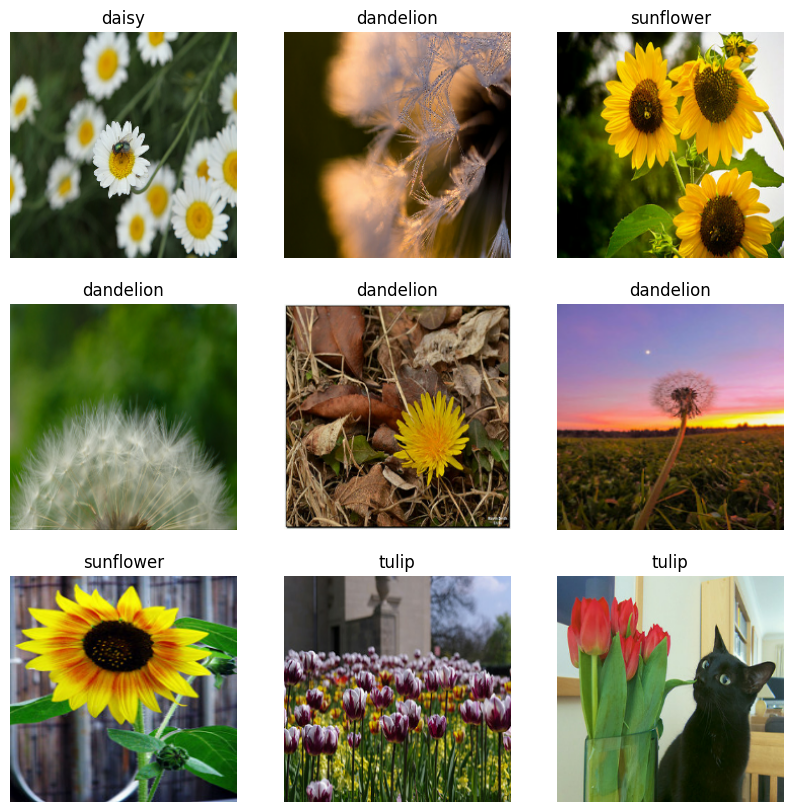

In [6]:
# --- CORRECTED DATA LOADING AND SPLITTING ---

# First, load the entire dataset from the main training directory without splitting it yet.
full_dataset = image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True # Shuffle the full dataset before splitting
)

# Get the class names from the full dataset
class_names = full_dataset.class_names
num_classes = len(class_names)
print('Classes:', class_names)
print(f'Number of classes: {num_classes}')

# Determine the size of the dataset
dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()
print(f"Total batches in the dataset: {dataset_size}")

# Define split sizes
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size # The rest goes to test

print(f"Training batches: {train_size}, Validation batches: {val_size}, Test batches: {test_size}")

# Use take() and skip() to create the splits
train_ds = full_dataset.take(train_size)
val_ds = full_dataset.skip(train_size).take(val_size)
test_ds = full_dataset.skip(train_size + val_size).take(test_size)

# Manually set shuffle=False for the test_ds for evaluation consistency
# This is a bit of a workaround since we can't set it during creation
test_ds = test_ds.unbatch().batch(BATCH_SIZE, drop_remainder=False)

print("\nSuccessfully created train, validation, and test datasets from the 'train' directory.")

# Display sample images from the new training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Convert tensor to numpy and ensure it's in the right format for imshow
        img_to_show = images[i].numpy().astype("uint8")
        plt.imshow(img_to_show)
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

#### Data Augmentation and Performance Tuning
We will apply data augmentation to the training set to prevent overfitting and improve generalization. We also use `.cache()` and `.prefetch()` to optimize the data loading pipeline.

In [7]:
# Data augmentation layers
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Apply augmentation only to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

# Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 3. Model 1: Simple CNN (Baseline)
Define and implement a simple CNN architecture as our baseline model.

In [8]:
def build_simple_cnn(input_shape, num_classes):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

simple_cnn_model = build_simple_cnn((IMG_HEIGHT, IMG_WIDTH, 3), num_classes)
simple_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
print("--- Training Baseline CNN Model ---")
history_simple_cnn = simple_cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

--- Training Baseline CNN Model ---
Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 633ms/step - accuracy: 0.4182 - loss: 1.4193 - val_accuracy: 0.5195 - val_loss: 1.1717
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 596ms/step - accuracy: 0.5846 - loss: 1.0260 - val_accuracy: 0.5859 - val_loss: 1.0921
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 552ms/step - accuracy: 0.6889 - loss: 0.8071 - val_accuracy: 0.5742 - val_loss: 1.2825
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 522ms/step - accuracy: 0.7927 - loss: 0.5711 - val_accuracy: 0.5938 - val_loss: 1.3972
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 611ms/step - accuracy: 0.8442 - loss: 0.4256 - val_accuracy: 0.5547 - val_loss: 1.5946
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 620ms/step - accuracy: 0.8801 - loss: 0.3437 - val_accuracy: 0.4805 - val_loss: 2.4548
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 543ms/step - accuracy: 0.8837 - loss: 0.3292 - val_accuracy: 0.5625 - val_loss: 2.5126
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 497ms/step - accura

### 4. Model 2: VGG16 (Transfer Learning)
Here we use the VGG16 model, pre-trained on ImageNet. We freeze the convolutional base and train a new classifier on top.

In [10]:
def build_transfer_model(base_model_class, input_shape, num_classes, fine_tune=False):
    # Preprocessing layer specific to the model
    preprocess_input = tf.keras.applications.vgg16.preprocess_input if base_model_class == VGG16 else tf.keras.applications.mobilenet_v2.preprocess_input
    
    # Base model from keras.applications
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False # Freeze the base

    # Create new model on top
    inputs = keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

vgg16_model = build_transfer_model(VGG16, (IMG_HEIGHT, IMG_WIDTH, 3), num_classes)
vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │      2,565 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 2,565 (10.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
print("--- Training VGG16 Transfer Learning Model ---")
history_vgg16 = vgg16_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

--- Training VGG16 Transfer Learning Model ---
Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.3511 - loss: 3.7589 - val_accuracy: 0.5820 - val_loss: 1.7147
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.6199 - loss: 1.5577 - val_accuracy: 0.6992 - val_loss: 1.1802
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7031 - loss: 1.0747 - val_accuracy: 0.7461 - val_loss: 1.0478
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.7495 - loss: 0.8527 - val_accuracy: 0.7617 - val_loss: 0.9050
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7753 - loss: 0.7158 - val_accuracy: 0.7812 - val_loss: 0.8155
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.7937 - loss: 0.6852 - val_accuracy: 0.7812 - val_loss: 0.8459
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8102 - loss: 0.5732 - val_accuracy: 0.7930 - val_loss: 0.7898
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0

### 5. Model 3: MobileNetV2 (Transfer Learning)
MobileNetV2 is a more modern and efficient architecture. We will use it in the same transfer learning setup.

In [12]:
mobilenet_model = build_transfer_model(MobileNetV2, (IMG_HEIGHT, IMG_WIDTH, 3), num_classes)
mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
print("--- Training MobileNetV2 Transfer Learning Model ---")
history_mobilenet = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

--- Training MobileNetV2 Transfer Learning Model ---
Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 462ms/step - accuracy: 0.6158 - loss: 0.9876 - val_accuracy: 0.7852 - val_loss: 0.5971
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 449ms/step - accuracy: 0.8019 - loss: 0.5360 - val_accuracy: 0.8203 - val_loss: 0.4672
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 451ms/step - accuracy: 0.8410 - loss: 0.4413 - val_accuracy: 0.8633 - val_loss: 0.4114
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 449ms/step - accuracy: 0.8690 - loss: 0.3729 - val_accuracy: 0.8711 - val_loss: 0.3845
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 445ms/step - accuracy: 0.8810 - loss: 0.3297 - val_accuracy: 0.8633 - val_loss: 0.3789
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 449ms/step - accuracy: 0.8952 - loss: 0.2992 - val_accuracy: 0.8672 - val_loss: 0.3629
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 454ms/step - accuracy: 0.9021 - loss: 0.2709 - val_accuracy: 0.8750 - val_loss: 0.3737
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 44

### 6. Model Comparison and Selection
Now we will evaluate all three trained models on the unseen test set to compare their performance and select the best one.

In [14]:
# Evaluate all models on the test set
print("Evaluating Baseline CNN...")
loss_cnn, acc_cnn = simple_cnn_model.evaluate(test_ds)

print("\nEvaluating VGG16 Model...")
loss_vgg, acc_vgg = vgg16_model.evaluate(test_ds)

print("\nEvaluating MobileNetV2 Model...")
loss_mobile, acc_mobile = mobilenet_model.evaluate(test_ds)

# Create a comparison table
results = pd.DataFrame({
    'Model': ['Simple CNN', 'VGG16', 'MobileNetV2'],
    'Test Loss': [loss_cnn, loss_vgg, loss_mobile],
    'Test Accuracy': [acc_cnn, acc_vgg, acc_mobile]
})

print("\n--- Model Comparison on Test Data ---")
results_sorted = results.sort_values(by='Test Accuracy', ascending=False)
print(results_sorted)

Evaluating Baseline CNN...
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5446 - loss: 3.7592

Evaluating VGG16 Model...


c:\Users\Ammad\Documents\Projects\Personal\Flower-AI\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8312 - loss: 0.6699

Evaluating MobileNetV2 Model...
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 403ms/step - accuracy: 0.8758 - loss: 0.3812

--- Model Comparison on Test Data ---
         Model  Test Loss  Test Accuracy
2  MobileNetV2   0.381178       0.875796
1        VGG16   0.669877       0.831210
0   Simple CNN   3.759210       0.544586


#### Visualize Training History
Plotting the training and validation accuracy helps us understand how each model learned and if there was any overfitting.

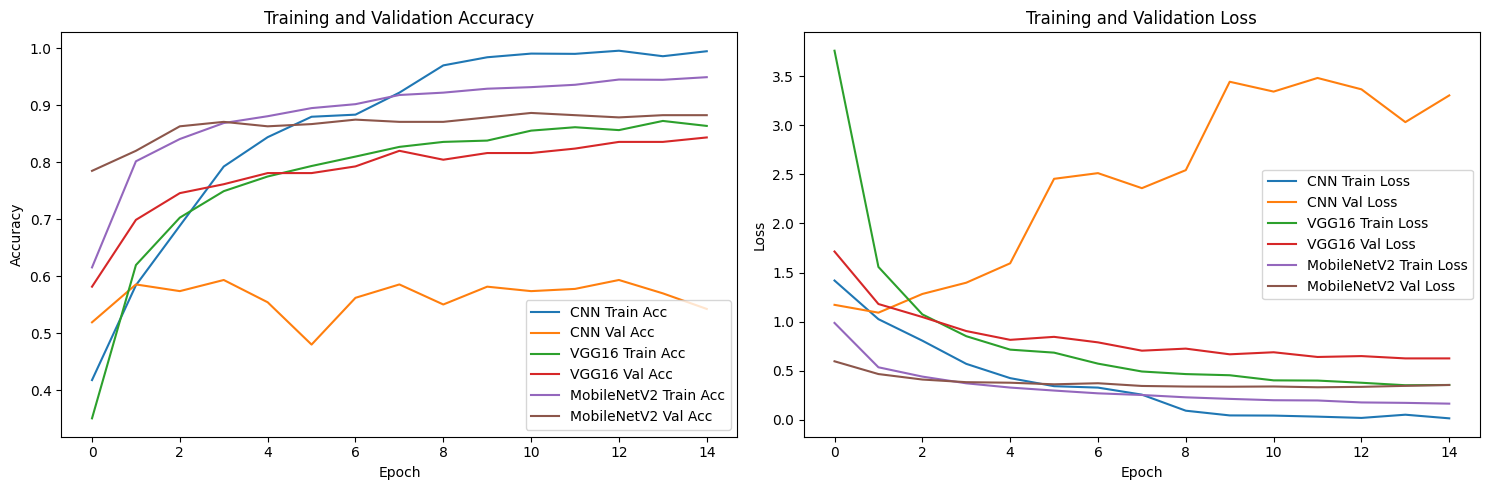

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_simple_cnn.history['accuracy'], label='CNN Train Acc')
plt.plot(history_simple_cnn.history['val_accuracy'], label='CNN Val Acc')
plt.plot(history_vgg16.history['accuracy'], label='VGG16 Train Acc')
plt.plot(history_vgg16.history['val_accuracy'], label='VGG16 Val Acc')
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2 Train Acc')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNetV2 Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_simple_cnn.history['loss'], label='CNN Train Loss')
plt.plot(history_simple_cnn.history['val_loss'], label='CNN Val Loss')
plt.plot(history_vgg16.history['loss'], label='VGG16 Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='VGG16 Val Loss')
plt.plot(history_mobilenet.history['loss'], label='MobileNetV2 Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='MobileNetV2 Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### Detailed Evaluation: Classification Report and Confusion Matrix
We will now generate a detailed report for each model to inspect precision, recall, and F1-score, along with a confusion matrix to see where the models are making mistakes.

--- Performance Report for Simple CNN ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
Classification Report:
              precision    recall  f1-score   support

       daisy       0.85      0.28      0.42        61
   dandelion       0.51      0.85      0.64        66
        rose       0.57      0.35      0.43        66
   sunflower       0.53      0.68      0.60        47
       tulip       0.51      0.58      0.54        74

    accuracy                           0.54       314
   macro avg       0.60      0.55      0.53       314
weighted avg       0.59      0.54      0.52       314



c:\Users\Ammad\Documents\Projects\Personal\Flower-AI\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


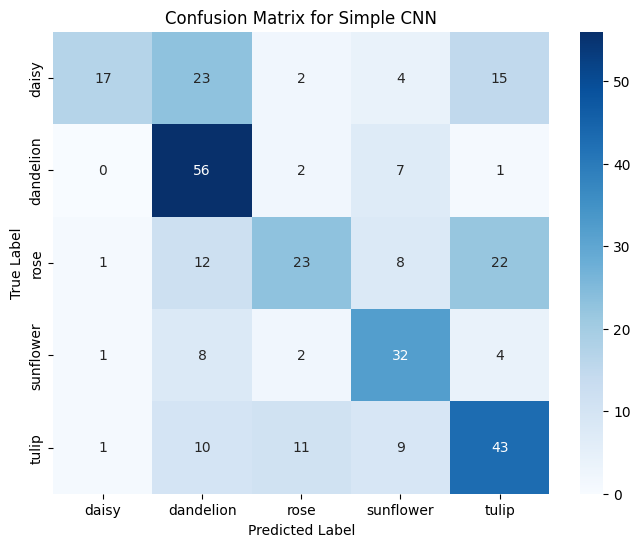

--- Performance Report for VGG16 ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Classification Report:
              precision    recall  f1-score   support

       daisy       0.87      0.75      0.81        61
   dandelion       0.89      0.94      0.91        66
        rose       0.85      0.77      0.81        66
   sunflower       0.76      0.87      0.81        47
       tulip       0.79      0.82      0.81        74

    accuracy                           0.83       314
   macro avg       0.83      0.83      0.83       314
weighted avg       0.83      0.83      0.83       314



c:\Users\Ammad\Documents\Projects\Personal\Flower-AI\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


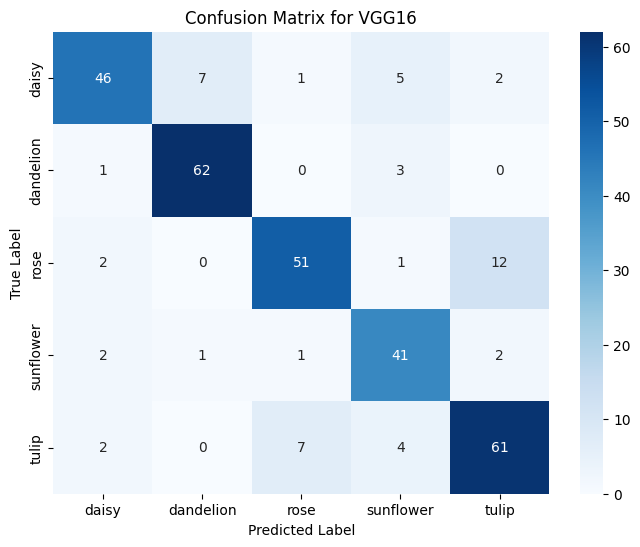

--- Performance Report for MobileNetV2 ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step
Classification Report:
              precision    recall  f1-score   support

       daisy       0.87      0.87      0.87        61
   dandelion       0.94      0.92      0.93        66
        rose       0.91      0.77      0.84        66
   sunflower       0.91      0.91      0.91        47
       tulip       0.79      0.91      0.84        74

    accuracy                           0.88       314
   macro avg       0.88      0.88      0.88       314
weighted avg       0.88      0.88      0.88       314



c:\Users\Ammad\Documents\Projects\Personal\Flower-AI\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


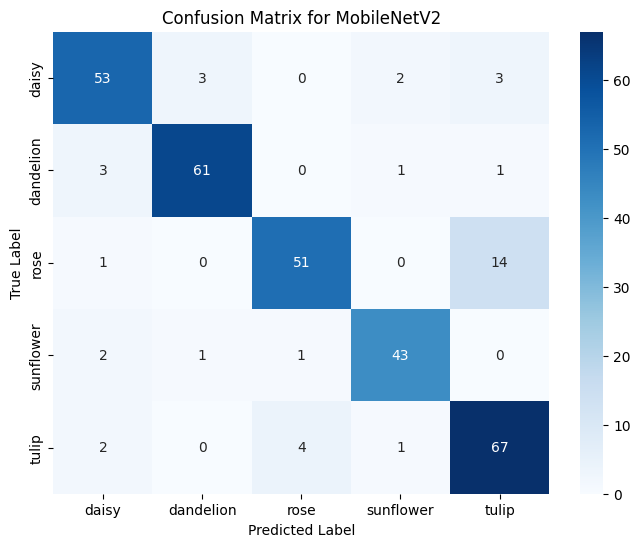

In [16]:
# Function to plot confusion matrix and print classification report
def evaluate_model_performance(model, model_name):
    print(f"--- Performance Report for {model_name} ---")
    # Get true labels
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    
    # Get predicted labels
    y_pred_probs = model.predict(test_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Evaluate each model
evaluate_model_performance(simple_cnn_model, 'Simple CNN')
evaluate_model_performance(vgg16_model, 'VGG16')
evaluate_model_performance(mobilenet_model, 'MobileNetV2')


### Analysis of VGG16 Model (Model 2)

This is a massive improvement over the baseline.

*   **Healthy Learning Trend:** Both `accuracy` and `val_accuracy` increase together. The `loss` and `val_loss` decrease together. This is the sign of a healthy, stable training process.
*   **No Overfitting:** At the end of training (Epoch 15), the `accuracy` is `0.8640` (86.4%) and the `val_accuracy` is `0.8438` (84.4%). These two numbers are very close! This means the model is **generalizing very well**. It's not just memorizing the training data; it's learning the actual features of the flowers.
*   **Great Performance:** A final validation accuracy of over 84% is a very strong result.
*   **The Trade-off: Speed:** Notice the time per step is around `2s/step`. VGG16 is a very large and powerful model, but it is computationally heavy and slow to train.

**Conclusion for VGG16:** A huge success. It completely solved the overfitting problem seen in the baseline model and achieved high accuracy.

---

### Analysis of MobileNetV2 Model (Model 3)

This result is even better, showcasing the advantages of a more modern architecture.

*   **Exceptional Performance:** The final `val_accuracy` is `0.8828` (88.3%). This is the **highest accuracy of all three models so far**.
*   **Incredibly Fast Learning:** Look at Epoch 1! The `val_accuracy` is already at `0.7852` (78.5%). It learned more in one epoch than the baseline model did in 15. The model reaches high accuracy very quickly.
*   **Efficiency is Key:** The training time is around `450ms/step` (0.45s/step). This is roughly **4 times faster** than the VGG16 model. You get better accuracy in a fraction of the time.
*   **Very Minor Overfitting:** At the end, the training `accuracy` is `0.9494` (94.9%) while the `val_accuracy` is `0.8828` (88.3%). There's a small gap, which indicates a tiny degree of overfitting, but it's completely acceptable and the model is still generalizing extremely well.

**Conclusion for MobileNetV2:** Outstanding. It's faster, more efficient, and ultimately more accurate than VGG16 for this task.

---

### Summary and Comparison

| Metric | Simple CNN (Baseline) | VGG16 (Transfer Learning) | MobileNetV2 (Transfer Learning) |
| :--- | :--- | :--- | :--- |
| **Final Val Accuracy** | ~54.3% | **~84.4%** | **~88.3% (Winner)** |
| **Final Val Loss** | ~3.30 (Very High) | **~0.62 (Good)** | **~0.35 (Excellent)** |
| **Signs of Overfitting?**| **Severe** | Almost None | Very Minor |
| **Training Speed** | Medium | Slow | **Very Fast (Winner)** |

### The Final Verdict

Your results perfectly demonstrate the core lesson of this project:

1.  **Transfer learning is incredibly effective.** By using a model that was pre-trained on a massive dataset (ImageNet), you start with a network that already understands basic visual features like edges, textures, and shapes. This prevents overfitting and leads to much higher accuracy.

2.  **Architecture matters.** MobileNetV2 is a more modern and efficient architecture than VGG16. For most tasks, it provides a better balance of speed and accuracy, and in this case, it was superior in both.

The next steps in your notebook—evaluating these models on the unseen **test set**—will be the final confirmation, but based on this training data, **MobileNetV2 is the clear winner and the best model for your project.**